In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from scipy.stats import randint as sp_randint
import itertools
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation

# Helper function to save figure
def savefig(name, pad=0.1,):
    path = os.path.join('images', name + '.png')
    plt.savefig(path, bbox_inches='tight', pad_inches=pad)

In [258]:
# Visual Helpers

def plot_regression_result(true, pred, title='', n=200, ax=None):
    if ax is None:
        plt.plot(true, pred, '.', alpha=0.6, markersize=13)
        plt.plot(np.arange(n), np.arange(n), color='black')
        plt.title(title, fontsize=18)
        plt.xlim(0,n)
        plt.xlabel('True RUL')
        plt.ylim(0,n)
        plt.ylabel('Predicted RUL')
    else:
        ax.scatter(true, pred)
        ax.plot(np.arange(n), np.arange(n), color='black')
        ax.set_title(title, fontsize=18)
        ax.set_xlim(0,n)
        ax.set_xlabel('True RUL')
        ax.set_ylim(0,n)
        ax.set_ylabel('Predicted RUL')
        
def plot_cm(y_test, y_pred, title, multi=False, ax=None):

    if multi:
        classes=[0,1,2]
    else:
        classes=[0,1]

    cm = confusion_matrix(y_test, y_pred, labels=classes)
    tick_marks = np.arange(len(classes))
    thresh = cm.max() / 2.
    
    if ax is None:
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.xticks(tick_marks)
        plt.yticks(tick_marks)
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=16)
        plt.title(title, fontsize=18)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, cm[i, j], horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=16)
        ax.set_title(title, fontsize=18)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

In [255]:
def save_results():
    results_df_cv.to_csv('data/results/results_cv.csv', index=False)
    results_df_test.to_csv('data/results/results_test.csv', index=False)
    
def get_results():
    results_df_cv = pd.read_csv('data/results/results_cv.csv')
    results_df_test = pd.read_csv('data/results/results_test.csv')
    results_df_cv.index=['RUL', 'Label1', 'Label2']
    results_df_test.index=['RUL', 'Label1', 'Label2']
    return results_df_cv, results_df_test

In [275]:
# Dataset Helpers

def create_dataset(train, test, features, target):
    return train[features], test[features], train[target], test[target]

def get_feature_sequence(df, lookback):
    data = df.values
    return np.asarray([data[i: i+lookback, :] for i in range(data.shape[0] - lookback)])

def get_udf(df, uid): 
    return df[df.id == uid]

def get_lstm_X_sequences(train_df, test_df, features, lookback):
    train_ids = train_df.id.unique()
    test_ids = test_df.id.unique()
    
    X_train = np.concatenate(
        [get_feature_sequence(get_udf(train_df, uid)[features], lookback) 
        for uid in train_ids]).astype(np.float32)
    
    X_test = np.asarray(
        [get_udf(test_df, uid)[features].values[-lookback:] 
        for uid in test_ids if get_udf(test_df, uid).shape[0] >= lookback]
        ).astype(np.float32)
    
    return X_train, X_test

def get_lstm_y_sequences(train_df, test_df, target, lookback, offset=1):
    train_ids = train_df.id.unique()
    test_ids = test_df.id.unique()
    
    y_train = np.concatenate(
        [get_udf(train_df, uid)[target].values[lookback:] for uid in train_ids]
    ).astype(np.float32)
    
    if target == 'RUL_norm' or target == 'RUL_max_norm':
        target = 'RUL'
    
    y_mask = [len(get_udf(test_df, uid)) >= lookback for uid in test_ids]
    y_test = test_df.groupby('id')[target].nth(-offset)[y_mask].values.reshape(-1,1).astype(np.float32)
    
    return y_train, y_test

def get_lstm_groups(train_df, lookback):    
    return np.concatenate([get_udf(train_df, uid).id.values[lookback:] for uid in train_ids]).astype(int) 

# Import Preprocessed Datasets

In [234]:
train_df = pd.read_csv('data/preprocessed/train_df.csv')
test_df = pd.read_csv('data/preprocessed/test_df.csv')

In [235]:
display(train_df.head())
display(test_df.head())

,RUL,RUL_norm,cycle,id,label1,label2,mean11,mean12,mean13,mean14,...,std2,std20,std21,std3,std4,std7,std8,std9,RUL_max,RUL_max_norm
0,191,0.529086,1,1,0,0,0.25119,0.736887,0.241176,0.166622,...,0.083115,0.05435,0.06194,0.087873,0.055933,0.059318,0.048152,0.024426,85,1.0
1,190,0.526316,2,1,0,0,0.25119,0.736887,0.241176,0.166622,...,0.083115,0.05435,0.06194,0.087873,0.055933,0.059318,0.048152,0.024426,85,1.0
2,189,0.523546,3,1,0,0,0.25119,0.736887,0.241176,0.166622,...,0.083115,0.05435,0.06194,0.087873,0.055933,0.059318,0.048152,0.024426,85,1.0
3,188,0.520776,4,1,0,0,0.25119,0.736887,0.241176,0.166622,...,0.083115,0.05435,0.06194,0.087873,0.055933,0.059318,0.048152,0.024426,85,1.0
4,187,0.518006,5,1,0,0,0.25119,0.736887,0.241176,0.166622,...,0.083115,0.05435,0.06194,0.087873,0.055933,0.059318,0.048152,0.024426,85,1.0


,RUL,RUL_norm,cycle,id,label1,label2,mean11,mean12,mean13,mean14,...,std15,std17,std2,std20,std21,std3,std4,std7,std8,std9
0,142,0.393352,1,1,0,0,0.272619,0.693603,0.251471,0.162504,...,0.078561,0.088279,0.115031,0.072724,0.050545,0.086846,0.088735,0.055753,0.031297,0.017171
1,141,0.390582,2,1,0,0,0.272619,0.693603,0.251471,0.162504,...,0.078561,0.088279,0.115031,0.072724,0.050545,0.086846,0.088735,0.055753,0.031297,0.017171
2,140,0.387812,3,1,0,0,0.272619,0.693603,0.251471,0.162504,...,0.078561,0.088279,0.115031,0.072724,0.050545,0.086846,0.088735,0.055753,0.031297,0.017171
3,139,0.385042,4,1,0,0,0.272619,0.693603,0.251471,0.162504,...,0.078561,0.088279,0.115031,0.072724,0.050545,0.086846,0.088735,0.055753,0.031297,0.017171
4,138,0.382271,5,1,0,0,0.272619,0.693603,0.251471,0.162504,...,0.078561,0.088279,0.115031,0.072724,0.050545,0.086846,0.088735,0.055753,0.031297,0.017171


In [227]:
# Column Helpers

sensor_columns = ['s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
agg_cols = ['mean2', 'mean3', 'mean4', 'mean7', 'mean8', 'mean9', 'mean11', 
            'mean12', 'mean13', 'mean14', 'mean15', 'mean17', 'mean20', 'mean21', 
            'std2', 'std3', 'std4', 'std7', 'std8', 'std9', 'std11', 'std12', 
            'std13', 'std14', 'std15', 'std17', 'std20', 'std21']
feature_columns = sensor_columns + agg_cols

# Metrics

In [78]:
def rul_performance_metric(true, pred):
    error = pred.reshape(-1) - true.reshape(-1)
    return np.mean(np.where(error < 0, np.exp(-error/14) - 1, np.exp(error/11) - 1))

def label_performance_metric(true, pred):
    error = pred.reshape(-1) - true.reshape(-1)
    return np.mean(np.where(error < 0, -2*error, error))

# For Keras Models

def rul_performance_metric_keras(y_true, y_pred):
    error = y_pred - y_true
    return  K.mean(K.tf.where(error < 0, K.exp(-error/14) - 1, K.exp(error/11) - 1))

def label_performance_metric_keras(y_true, y_pred):
    error = y_pred - y_true
    return K.mean(K.tf.where(error < 0, -2*error, error))

In [248]:
# Crossval Score Helpers

def rul_score(model, X, y, cv=10):
    return cross_val_score(model, X, y, groups=train_df.id, cv=cv, scoring=make_scorer(rul_performance_metric)).mean()

def label_score(model, X, y, cv=10):
    return cross_val_score(model, X, y, groups=train_df.id, cv=cv, scoring=make_scorer(label_performance_metric)).mean()

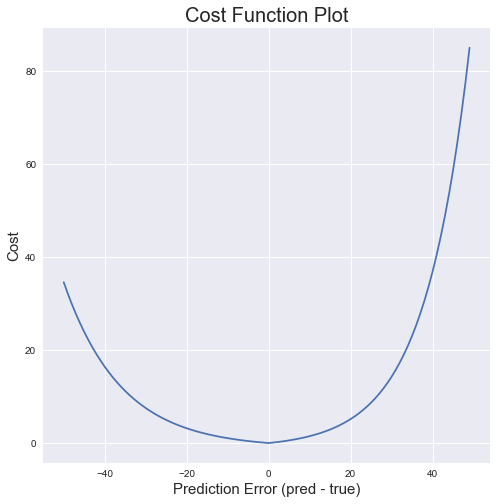

In [8]:
def rul_cost_function_plot(error):
    return np.exp(-error/14) - 1 if error < 0 else np.exp(error/11) - 1

plt.figure(figsize=(8,8))
pred_error = np.arange(-50, 50)
cost_error = np.asarray([rul_cost_function_plot(error) for error in pred_error])
plt.plot(pred_error, cost_error)
plt.title('Cost Function Plot', fontsize=20)
plt.xlabel('Prediction Error (pred - true)', fontsize=15)
plt.ylabel('Cost', fontsize=15)
savefig('cost_function_plot')

In [9]:
# Create Result Dataframes to store results
results_df_cv = pd.DataFrame(index=['RUL', 'Label1', 'Label2'])
results_df_test = pd.DataFrame(index=['RUL', 'Label1', 'Label2'])

# Create the train and test datasets

In [291]:
# Use only the sensor values as the input features
X_train = train_df[feature_columns]
y_train_rul = train_df['RUL']
y_train_label1 = train_df['label1']
y_train_label2 = train_df['label2']

# Use the last cycle for each engine unit as the test set
X_test = test_df.groupby('id')[feature_columns].last()
y_test_rul = test_df.groupby('id')['RUL'].last()
y_test_label1 = test_df.groupby('id')['label1'].last()
y_test_label2 = test_df.groupby('id')['label2'].last()

In [236]:
print(X_train.shape)
print(y_train_rul.shape)
print(X_test.shape)
print(y_test_rul.shape)

(20631, 42)
(20631,)
(100, 42)
(100,)


# Benchmark Linear Models

,Benchmark_CV,Benchmark_Test
RUL,5200.74,81.08
Label1,0.06,0.15
Label2,0.18,0.39


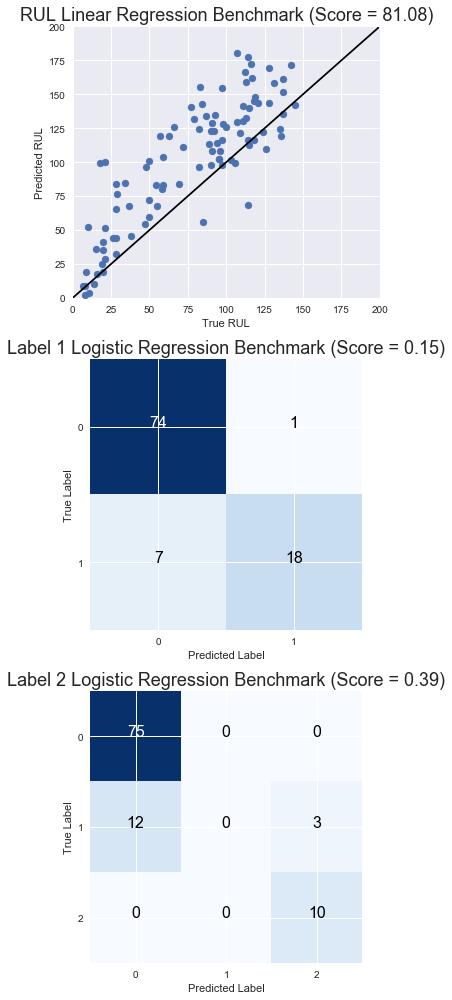

In [292]:
# Define the benchmark models for each target
rul_model = LinearRegression()
label1_model = LogisticRegression()
label2_model = LogisticRegression()

# CrossVal Scores
rul_cv_result = rul_score(rul_model, X_train, y_train_rul)
label1_cv_result = label1_score(label1_model, X_train, y_train_label1)
label2_cv_result = label2_score(label2_model, X_train, y_train_label2)

# Make predictions on test set
rul_pred = rul_model.fit(X_train, y_train_rul).predict(X_test)
label1_pred = label1_model.fit(X_train, y_train_label1).predict(X_test)
label2_pred = label2_model.fit(X_train, y_train_label2).predict(X_test)

# Get scores on test set
rul_test_score = rul_performance_metric(y_test_rul, rul_pred)
label1_test_score = label1_performance_metric(y_test_label1, label1_pred)
label2_test_score = label2_performance_metric(y_test_label2, label2_pred)

results_df_cv['Benchmark_CV'] = [rul_cv_result, label1_cv_result, label2_cv_result]
results_df_test['Benchmark_Test'] = [rul_test_score, label1_test_score, label2_test_score]

display(pd.concat([results_df_cv, results_df_test], axis=1)[['Benchmark_CV', 'Benchmark_Test']].round(2))


titles = [
    'RUL Linear Regression Benchmark (Score = {0:.2f})'.format(rul_test_score),
    'Label 1 Logistic Regression Benchmark (Score = {0:.2f})'.format(label1_test_score),
    'Label 2 Logistic Regression Benchmark (Score = {0:.2f})'.format(label2_test_score)
]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,14))
plot_regression_result(y_test_rul, rul_pred, title=titles[0], n=200, ax=ax1)
plot_cm(y_test_label1, label1_pred, titles[1], multi=False, ax=ax2)
plot_cm(y_test_label2, label2_pred, titles[2], multi=True, ax=ax3)
plt.tight_layout()
savefig('benchmark_results')

## Random Forrest Models

,RandomForrest_CV,RandomForrest_Test
RUL,21410.33,5648.69
Label1,0.07,0.17
Label2,0.15,0.32


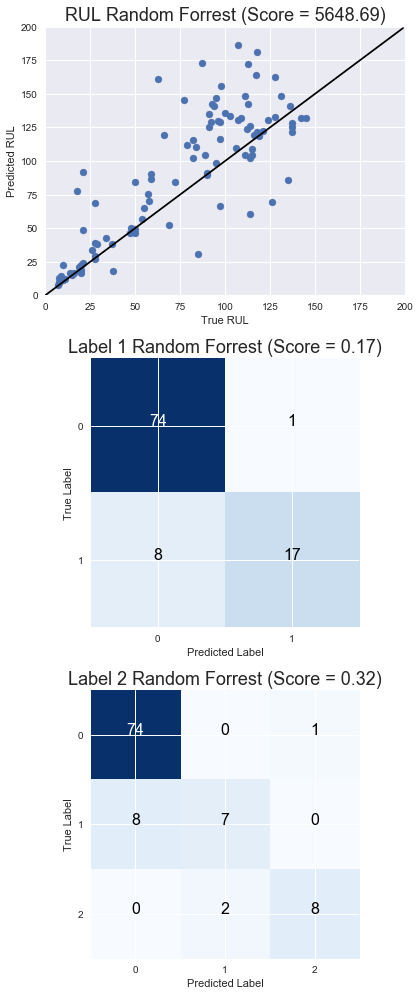

In [260]:
rul_model = RandomForestRegressor(random_state=42)
label1_model = RandomForestClassifier(random_state=42)
label2_model = RandomForestClassifier(random_state=42)

# CrossVal Scores
rul_cv_result = rul_score(rul_model, X_train, y_train_rul)
label1_cv_result = label1_score(label1_model, X_train, y_train_label1)
label2_cv_result = label2_score(label2_model, X_train, y_train_label2)

# Make predictions on test set
rul_pred = rul_model.fit(X_train, y_train_rul).predict(X_test)
label1_pred = label1_model.fit(X_train, y_train_label1).predict(X_test)
label2_pred = label2_model.fit(X_train, y_train_label2).predict(X_test)

# Get scores on test set
rul_test_score = rul_performance_metric(y_test_rul, rul_pred)
label1_test_score = label1_performance_metric(y_test_label1, label1_pred)
label2_test_score = label2_performance_metric(y_test_label2, label2_pred)

results_df_cv['RandomForrest_CV'] = [rul_cv_result, label1_cv_result, label2_cv_result]
results_df_test['RandomForrest_Test'] = [rul_test_score, label1_test_score, label2_test_score]

display(pd.concat([results_df_cv, results_df_test], axis=1)[['RandomForrest_CV', 'RandomForrest_Test']].round(2))


titles = [
    'RUL Random Forrest (Score = {0:.2f})'.format(rul_test_score),
    'Label 1 Random Forrest (Score = {0:.2f})'.format(label1_test_score),
    'Label 2 Random Forrest (Score = {0:.2f})'.format(label2_test_score)
]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,14))
plot_regression_result(y_test_rul, rul_pred, title=titles[0], n=200, ax=ax1)
plot_cm(y_test_label1, label1_pred, titles[1], multi=False, ax=ax2)
plot_cm(y_test_label2, label2_pred, titles[2], multi=True, ax=ax3)
plt.tight_layout()
savefig('rf_results')

## Random Forrest Parameter Tuning with Grid Search

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 52.2min finished


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 20.6min finished


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 21.3min finished


RUL Model Best Params: {'min_samples_leaf': 1, 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': None, 'n_estimators': 5}
Label 1 Model Best Params: {'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 5, 'max_features': 'auto'}
Label 2 Model Best Params: {'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 5, 'max_features': 'log2'}


,RandomForrest_CV_tuned,RandomForrest_Test_tuned
RUL,46637.68,521.82
Label1,0.07,0.15
Label2,0.16,0.38


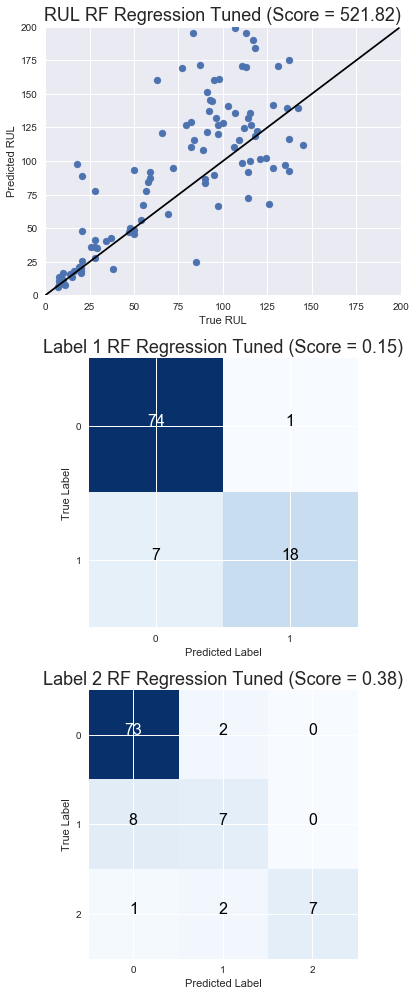

In [189]:
# Define the models for each target
rul_model = RandomForestRegressor(random_state=42)
label1_model = RandomForestClassifier(random_state=42)
label2_model = RandomForestClassifier(random_state=42)

# Use a grid over parameters of interest
rul_param_grid = {"n_estimators" : [5, 10, 50],
                  "max_depth": [None, 5, 20],
                  "min_samples_split": [2, 5],
                  "min_samples_leaf": [1, 5],
                  "max_features" : ["auto", "log2"]
                 }

label_param_grid = {"n_estimators" : [5, 10, 50],
                    "max_depth": [None, 5, 20],
                    "min_samples_split": [2, 5],
                    "min_samples_leaf": [1, 5],
                    "criterion" : ['gini', 'entropy'],
                    "max_features" : ['auto', 'log2']
                   }

rul_grid = GridSearchCV(estimator=rul_model, param_grid=rul_param_grid, 
                        cv=list(GroupKFold(n_splits=10).split(X_train, y_train_rul, groups=train_df['id'])), 
                        scoring=make_scorer(rul_performance_metric), verbose=1)

label1_grid = GridSearchCV(estimator=label1_model, param_grid=label_param_grid, 
                           cv=list(GroupKFold(n_splits=10).split(X_train, y_train_label1, groups=train_df['id'])), 
                           scoring=make_scorer(label1_performance_metric), verbose=1)

label2_grid = GridSearchCV(estimator=label2_model, param_grid=label_param_grid, 
                           cv=list(GroupKFold(n_splits=10).split(X_train, y_train_label2, groups=train_df['id'])), 
                           scoring=make_scorer(label2_performance_metric), verbose=1)

rul_grid.fit(X_train, y_train_rul)
label1_grid.fit(X_train, y_train_label1)
label2_grid.fit(X_train, y_train_label2)

# Print the best params
print("RUL Model Best Params:", rul_grid.best_params_)
print("Label 1 Model Best Params:", label1_grid.best_params_)
print("Label 2 Model Best Params:", label2_grid.best_params_)

# Cross Val Scores
rul_cv_result = rul_grid.best_score_
label1_cv_result = label1_grid.best_score_
label2_cv_result = label2_grid.best_score_

# Make predictions on test set with the best models
rul_pred = rul_grid.best_estimator_.fit(X_train, y_train_rul).predict(X_test)
label1_pred = label1_grid.best_estimator_.fit(X_train, y_train_label1).predict(X_test)
label2_pred = label2_grid.best_estimator_.fit(X_train, y_train_label2).predict(X_test)

# Get scores on test set
rul_test_score = rul_performance_metric(y_test_rul, rul_pred)
label1_test_score = label1_performance_metric(y_test_label1, label1_pred)
label2_test_score = label2_performance_metric(y_test_label2, label2_pred)

results_df_cv['RandomForrest_CV_tuned'] = [rul_cv_result, label1_cv_result, label2_cv_result]
results_df_test['RandomForrest_Test_tuned'] = [rul_test_score, label1_test_score, label2_test_score]

display(pd.concat([results_df_cv, results_df_test], axis=1)[['RandomForrest_CV_tuned', 'RandomForrest_Test_tuned']].round(2))

titles = [
    'RUL RF Regression Tuned (Score = {0:.2f})'.format(rul_test_score),
    'Label 1 RF Regression Tuned (Score = {0:.2f})'.format(label1_test_score),
    'Label 2 RF Regression Tuned (Score = {0:.2f})'.format(label2_test_score)
]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,14))
plot_regression_result(y_test_rul, rul_pred, title=titles[0], n=200, ax=ax1)
plot_cm(y_test_label1, label1_pred, titles[1], multi=False, ax=ax2)
plot_cm(y_test_label2, label2_pred, titles[2], multi=True, ax=ax3)
plt.tight_layout()
savefig('rf_tuned_results')

## LSTM Models

## Hyper-parameter Tuning

In [31]:
group_kfold = GroupKFold(n_splits=10)
group_ids = list(group_kfold.split(X, y, groups))
ids_to_use = np.random.choice(len(group_ids), 3)

lookback = 50

rul_scaler = MinMaxScaler().fit(train_df.RUL.reshape(-1, 1))

X, _ = get_lstm_X_sequences(train_df, test_df, features=sensor_columns, lookback=lookback)
y, _ = get_lstm_y_sequences(train_df, test_df, target='RUL_norm', lookback=lookback)

groups = get_lstm_groups(train_df, lookback=lookback)

Epoch 1/10
14065/14065 [==============================] - 19s - loss: 0.0361 - rul_performance_metric_keras: 0.0113    
Epoch 2/10
14065/14065 [==============================] - 16s - loss: 0.0211 - rul_performance_metric_keras: 0.0085    
Epoch 3/10
14065/14065 [==============================] - 16s - loss: 0.0165 - rul_performance_metric_keras: 0.0077    
Epoch 4/10
14065/14065 [==============================] - 16s - loss: 0.0147 - rul_performance_metric_keras: 0.0074    
Epoch 5/10
14065/14065 [==============================] - 16s - loss: 0.0139 - rul_performance_metric_keras: 0.0073    
Epoch 6/10
14065/14065 [==============================] - 16s - loss: 0.0133 - rul_performance_metric_keras: 0.0071    
Epoch 7/10
14065/14065 [==============================] - 16s - loss: 0.0130 - rul_performance_metric_keras: 0.0071    
Epoch 8/10
14065/14065 [==============================] - 16s - loss: 0.0127 - rul_performance_metric_keras: 0.0069    
Epoch 9/10
14065/14065 [================

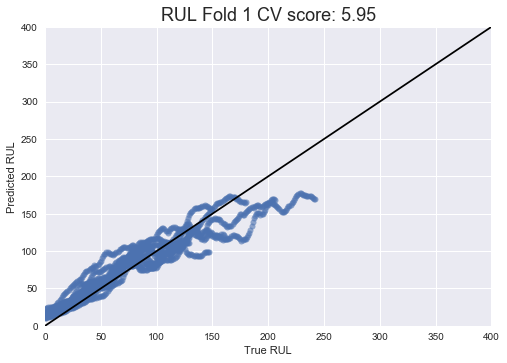

Epoch 1/10
14060/14060 [==============================] - 19s - loss: 0.0409 - rul_performance_metric_keras: 0.0116    
Epoch 2/10
14060/14060 [==============================] - 17s - loss: 0.0195 - rul_performance_metric_keras: 0.0081    
Epoch 3/10
14060/14060 [==============================] - 17s - loss: 0.0157 - rul_performance_metric_keras: 0.0075    
Epoch 4/10
14060/14060 [==============================] - 17s - loss: 0.0139 - rul_performance_metric_keras: 0.0072    
Epoch 5/10
14060/14060 [==============================] - 17s - loss: 0.0133 - rul_performance_metric_keras: 0.0070    
Epoch 6/10
14060/14060 [==============================] - 18s - loss: 0.0128 - rul_performance_metric_keras: 0.0069    
Epoch 7/10
14060/14060 [==============================] - 17s - loss: 0.0129 - rul_performance_metric_keras: 0.0070    
Epoch 8/10
14060/14060 [==============================] - 17s - loss: 0.0127 - rul_performance_metric_keras: 0.0070    
Epoch 9/10
14060/14060 [================

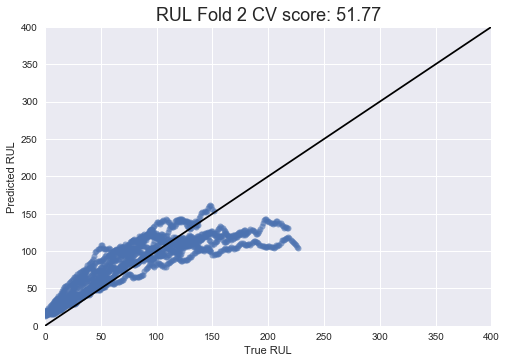

Epoch 1/10
14062/14062 [==============================] - 19s - loss: 0.0449 - rul_performance_metric_keras: 0.0124    
Epoch 2/10
14062/14062 [==============================] - 16s - loss: 0.0197 - rul_performance_metric_keras: 0.0082    
Epoch 3/10
14062/14062 [==============================] - 16s - loss: 0.0155 - rul_performance_metric_keras: 0.0073    
Epoch 4/10
14062/14062 [==============================] - 16s - loss: 0.0140 - rul_performance_metric_keras: 0.0071    
Epoch 5/10
14062/14062 [==============================] - 17s - loss: 0.0132 - rul_performance_metric_keras: 0.0070    
Epoch 6/10
14062/14062 [==============================] - 16s - loss: 0.0130 - rul_performance_metric_keras: 0.0070    
Epoch 7/10
14062/14062 [==============================] - 17s - loss: 0.0126 - rul_performance_metric_keras: 0.0070    
Epoch 8/10
14062/14062 [==============================] - 16s - loss: 0.0126 - rul_performance_metric_keras: 0.0070    
Epoch 9/10
14062/14062 [================

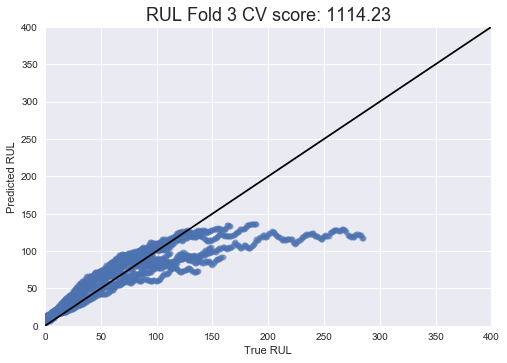

Mean CV Score: 390.6496276855469


In [33]:
def get_model():
    model = Sequential()
    model.add(LSTM(10, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=5, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/10
14065/14065 [==============================] - 31s - loss: 0.0254 - rul_performance_metric_keras: 0.0093    
Epoch 2/10
14065/14065 [==============================] - 29s - loss: 0.0144 - rul_performance_metric_keras: 0.0072    
Epoch 3/10
14065/14065 [==============================] - 29s - loss: 0.0128 - rul_performance_metric_keras: 0.0067    
Epoch 4/10
14065/14065 [==============================] - 28s - loss: 0.0122 - rul_performance_metric_keras: 0.0065    
Epoch 5/10
14065/14065 [==============================] - 29s - loss: 0.0117 - rul_performance_metric_keras: 0.0063    
Epoch 6/10
14065/14065 [==============================] - 29s - loss: 0.0124 - rul_performance_metric_keras: 0.0062    
Epoch 7/10
14065/14065 [==============================] - 29s - loss: 0.0099 - rul_performance_metric_keras: 0.0058    
Epoch 8/10
14065/14065 [==============================] - 29s - loss: 0.0098 - rul_performance_metric_keras: 0.0057    
Epoch 9/10
14065/14065 [================

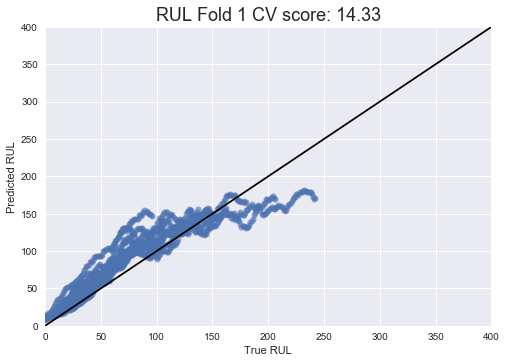

Epoch 1/10
14060/14060 [==============================] - 38s - loss: 0.0235 - rul_performance_metric_keras: 0.0090    
Epoch 2/10
14060/14060 [==============================] - 30s - loss: 0.0138 - rul_performance_metric_keras: 0.0070    
Epoch 3/10
14060/14060 [==============================] - 31s - loss: 0.0128 - rul_performance_metric_keras: 0.0067    
Epoch 4/10
14060/14060 [==============================] - 29s - loss: 0.0119 - rul_performance_metric_keras: 0.0064    
Epoch 5/10
14060/14060 [==============================] - 29s - loss: 0.0114 - rul_performance_metric_keras: 0.0062    
Epoch 6/10
14060/14060 [==============================] - 29s - loss: 0.0107 - rul_performance_metric_keras: 0.0060    
Epoch 7/10
14060/14060 [==============================] - 29s - loss: 0.0109 - rul_performance_metric_keras: 0.0058    
Epoch 8/10
14060/14060 [==============================] - 29s - loss: 0.0095 - rul_performance_metric_keras: 0.0056    
Epoch 9/10
14060/14060 [================

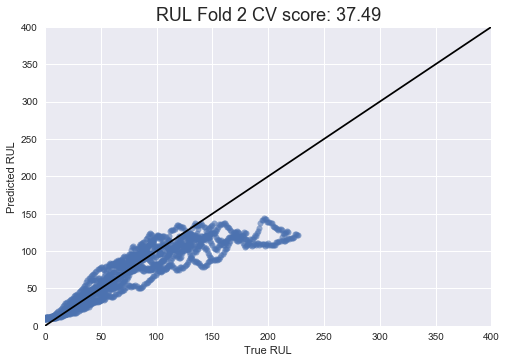

Epoch 1/10
14062/14062 [==============================] - 32s - loss: 0.0273 - rul_performance_metric_keras: 0.0095    
Epoch 2/10
14062/14062 [==============================] - 29s - loss: 0.0138 - rul_performance_metric_keras: 0.0071    
Epoch 3/10
14062/14062 [==============================] - 29s - loss: 0.0126 - rul_performance_metric_keras: 0.0066    
Epoch 4/10
14062/14062 [==============================] - 29s - loss: 0.0117 - rul_performance_metric_keras: 0.0064    
Epoch 5/10
14062/14062 [==============================] - 31s - loss: 0.0113 - rul_performance_metric_keras: 0.0062    
Epoch 6/10
14062/14062 [==============================] - 35s - loss: 0.0103 - rul_performance_metric_keras: 0.0059    
Epoch 7/10
14062/14062 [==============================] - 33s - loss: 0.0095 - rul_performance_metric_keras: 0.0056    
Epoch 8/10
14062/14062 [==============================] - 29s - loss: 0.0085 - rul_performance_metric_keras: 0.0053    
Epoch 9/10
14062/14062 [================

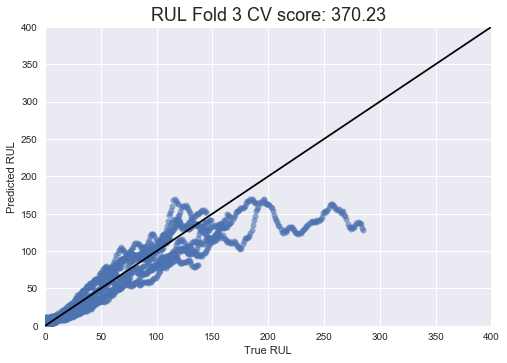

Mean CV Score: 140.6807403564453


In [34]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

lookback = 50
cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/10
14065/14065 [==============================] - 23s - loss: 0.0278 - rul_performance_metric_keras: 0.0101    
Epoch 2/10
14065/14065 [==============================] - 20s - loss: 0.0158 - rul_performance_metric_keras: 0.0075    
Epoch 3/10
14065/14065 [==============================] - 20s - loss: 0.0142 - rul_performance_metric_keras: 0.0070    
Epoch 4/10
14065/14065 [==============================] - 20s - loss: 0.0130 - rul_performance_metric_keras: 0.0066    
Epoch 5/10
14065/14065 [==============================] - 20s - loss: 0.0122 - rul_performance_metric_keras: 0.0064    
Epoch 6/10
14065/14065 [==============================] - 20s - loss: 0.0112 - rul_performance_metric_keras: 0.0062    
Epoch 7/10
14065/14065 [==============================] - 20s - loss: 0.0103 - rul_performance_metric_keras: 0.0059    
Epoch 8/10
14065/14065 [==============================] - 20s - loss: 0.0096 - rul_performance_metric_keras: 0.0057    
Epoch 9/10
14065/14065 [================

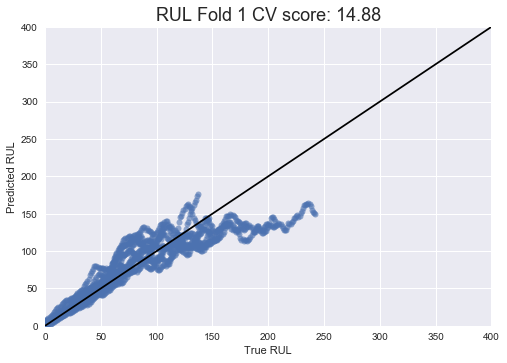

Epoch 1/10
14060/14060 [==============================] - 23s - loss: 0.0258 - rul_performance_metric_keras: 0.0095    
Epoch 2/10
14060/14060 [==============================] - 20s - loss: 0.0156 - rul_performance_metric_keras: 0.0074    
Epoch 3/10
14060/14060 [==============================] - 20s - loss: 0.0140 - rul_performance_metric_keras: 0.0070    
Epoch 4/10
14060/14060 [==============================] - 23s - loss: 0.0126 - rul_performance_metric_keras: 0.0065    
Epoch 5/10
14060/14060 [==============================] - 20s - loss: 0.0119 - rul_performance_metric_keras: 0.0063    
Epoch 6/10
14060/14060 [==============================] - 20s - loss: 0.0111 - rul_performance_metric_keras: 0.0061    
Epoch 7/10
14060/14060 [==============================] - 20s - loss: 0.0095 - rul_performance_metric_keras: 0.0056    
Epoch 8/10
14060/14060 [==============================] - 20s - loss: 0.0089 - rul_performance_metric_keras: 0.0054    
Epoch 9/10
14060/14060 [================

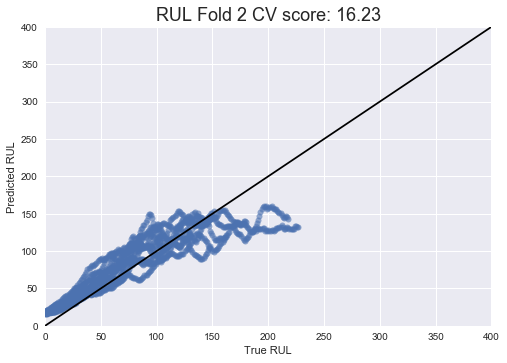

Epoch 1/10
14062/14062 [==============================] - 23s - loss: 0.0240 - rul_performance_metric_keras: 0.0091    
Epoch 2/10
14062/14062 [==============================] - 21s - loss: 0.0144 - rul_performance_metric_keras: 0.0071    
Epoch 3/10
14062/14062 [==============================] - 21s - loss: 0.0127 - rul_performance_metric_keras: 0.0066    
Epoch 4/10
14062/14062 [==============================] - 20s - loss: 0.0118 - rul_performance_metric_keras: 0.0064    
Epoch 5/10
14062/14062 [==============================] - 20s - loss: 0.0110 - rul_performance_metric_keras: 0.0062    
Epoch 6/10
14062/14062 [==============================] - 20s - loss: 0.0095 - rul_performance_metric_keras: 0.0057    
Epoch 7/10
14062/14062 [==============================] - 20s - loss: 0.0087 - rul_performance_metric_keras: 0.0054    
Epoch 8/10
14062/14062 [==============================] - 20s - loss: 0.0085 - rul_performance_metric_keras: 0.0053    
Epoch 9/10
14062/14062 [================

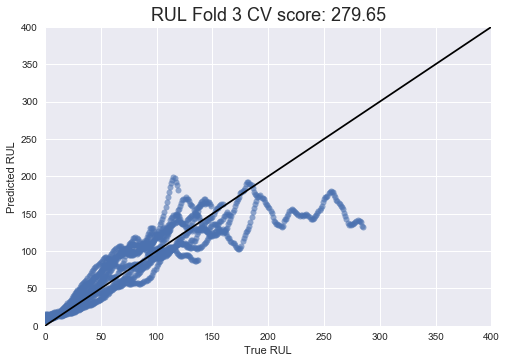

Mean CV Score: 103.58654022216797


In [35]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

lookback = 50
cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/10
14065/14065 [==============================] - 23s - loss: 0.0171 - rul_performance_metric_keras: 0.0078    
Epoch 2/10
14065/14065 [==============================] - 20s - loss: 0.0126 - rul_performance_metric_keras: 0.0067    
Epoch 3/10
14065/14065 [==============================] - 20s - loss: 0.0117 - rul_performance_metric_keras: 0.0064    
Epoch 4/10
14065/14065 [==============================] - 20s - loss: 0.0110 - rul_performance_metric_keras: 0.0062    
Epoch 5/10
14065/14065 [==============================] - 20s - loss: 0.0092 - rul_performance_metric_keras: 0.0055    
Epoch 6/10
14065/14065 [==============================] - 20s - loss: 0.0086 - rul_performance_metric_keras: 0.0053    
Epoch 7/10
14065/14065 [==============================] - 20s - loss: 0.0080 - rul_performance_metric_keras: 0.0051    
Epoch 8/10
14065/14065 [==============================] - 20s - loss: 0.0077 - rul_performance_metric_keras: 0.0049    
Epoch 9/10
14065/14065 [================

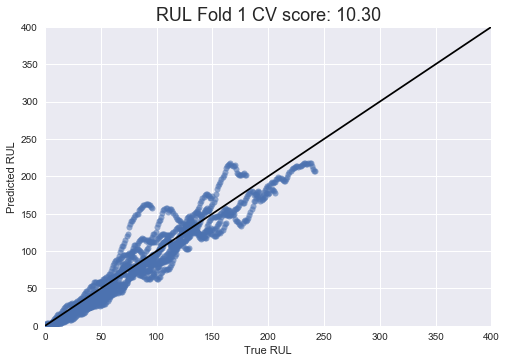

Epoch 1/10
14060/14060 [==============================] - 23s - loss: 0.0159 - rul_performance_metric_keras: 0.0076    
Epoch 2/10
14060/14060 [==============================] - 20s - loss: 0.0125 - rul_performance_metric_keras: 0.0067    
Epoch 3/10
14060/14060 [==============================] - 20s - loss: 0.0117 - rul_performance_metric_keras: 0.0064    
Epoch 4/10
14060/14060 [==============================] - 20s - loss: 0.0107 - rul_performance_metric_keras: 0.0061    
Epoch 5/10
14060/14060 [==============================] - 21s - loss: 0.0093 - rul_performance_metric_keras: 0.0055    
Epoch 6/10
14060/14060 [==============================] - 21s - loss: 0.0086 - rul_performance_metric_keras: 0.0053    
Epoch 7/10
14060/14060 [==============================] - 20s - loss: 0.0078 - rul_performance_metric_keras: 0.0050    
Epoch 8/10
14060/14060 [==============================] - 20s - loss: 0.0073 - rul_performance_metric_keras: 0.0048    
Epoch 9/10
14060/14060 [================

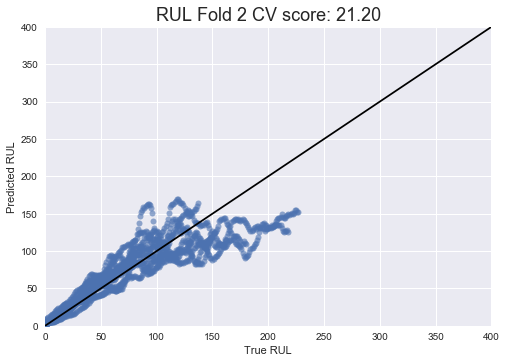

Epoch 1/10
14062/14062 [==============================] - 25s - loss: 0.0181 - rul_performance_metric_keras: 0.0082    
Epoch 2/10
14062/14062 [==============================] - 18s - loss: 0.0124 - rul_performance_metric_keras: 0.0067    
Epoch 3/10
14062/14062 [==============================] - 18s - loss: 0.0108 - rul_performance_metric_keras: 0.0062    
Epoch 4/10
14062/14062 [==============================] - 19s - loss: 0.0093 - rul_performance_metric_keras: 0.0056    
Epoch 5/10
14062/14062 [==============================] - 19s - loss: 0.0084 - rul_performance_metric_keras: 0.0052    
Epoch 6/10
14062/14062 [==============================] - 19s - loss: 0.0080 - rul_performance_metric_keras: 0.0051    
Epoch 7/10
14062/14062 [==============================] - 19s - loss: 0.0076 - rul_performance_metric_keras: 0.0049    
Epoch 8/10
14062/14062 [==============================] - 19s - loss: 0.0071 - rul_performance_metric_keras: 0.0047    
Epoch 9/10
14062/14062 [================

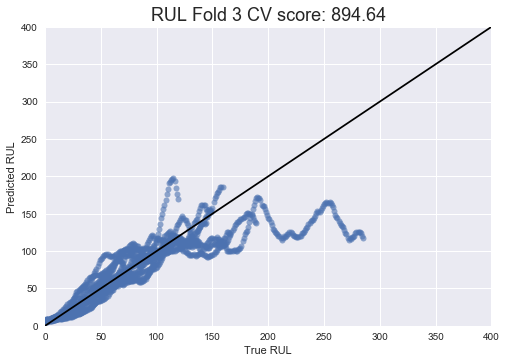

Mean CV Score: 308.71514892578125


In [36]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

lookback = 50
cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/10
14065/14065 [==============================] - 12s - loss: 0.0287 - rul_performance_metric_keras: 0.0103    
Epoch 2/10
14065/14065 [==============================] - 8s - loss: 0.0182 - rul_performance_metric_keras: 0.0082     
Epoch 3/10
14065/14065 [==============================] - 8s - loss: 0.0164 - rul_performance_metric_keras: 0.0076     
Epoch 4/10
14065/14065 [==============================] - 8s - loss: 0.0152 - rul_performance_metric_keras: 0.0074     
Epoch 5/10
14065/14065 [==============================] - 8s - loss: 0.0143 - rul_performance_metric_keras: 0.0071     
Epoch 6/10
14065/14065 [==============================] - 8s - loss: 0.0137 - rul_performance_metric_keras: 0.0070     
Epoch 7/10
14065/14065 [==============================] - 8s - loss: 0.0133 - rul_performance_metric_keras: 0.0069     
Epoch 8/10
14065/14065 [==============================] - 8s - loss: 0.0128 - rul_performance_metric_keras: 0.0068     
Epoch 9/10
14065/14065 [================

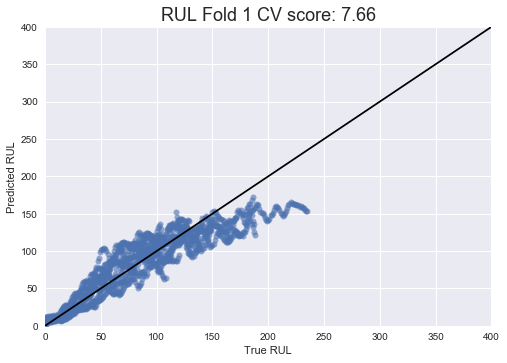

Epoch 1/10
14060/14060 [==============================] - 12s - loss: 0.0267 - rul_performance_metric_keras: 0.0097    
Epoch 2/10
14060/14060 [==============================] - 8s - loss: 0.0168 - rul_performance_metric_keras: 0.0077     
Epoch 3/10
14060/14060 [==============================] - 8s - loss: 0.0150 - rul_performance_metric_keras: 0.0072     
Epoch 4/10
14060/14060 [==============================] - 8s - loss: 0.0140 - rul_performance_metric_keras: 0.0069     
Epoch 5/10
14060/14060 [==============================] - 8s - loss: 0.0132 - rul_performance_metric_keras: 0.0067     
Epoch 6/10
14060/14060 [==============================] - 8s - loss: 0.0124 - rul_performance_metric_keras: 0.0065     
Epoch 7/10
14060/14060 [==============================] - 8s - loss: 0.0121 - rul_performance_metric_keras: 0.0065     
Epoch 8/10
14060/14060 [==============================] - 8s - loss: 0.0116 - rul_performance_metric_keras: 0.0063     
Epoch 9/10
14060/14060 [================

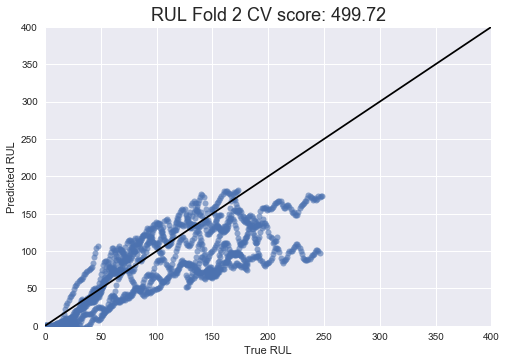

Epoch 1/10
14062/14062 [==============================] - 11s - loss: 0.0345 - rul_performance_metric_keras: 0.0107    
Epoch 2/10
14062/14062 [==============================] - 7s - loss: 0.0176 - rul_performance_metric_keras: 0.0079     
Epoch 3/10
14062/14062 [==============================] - 8s - loss: 0.0154 - rul_performance_metric_keras: 0.0074     
Epoch 4/10
14062/14062 [==============================] - 8s - loss: 0.0144 - rul_performance_metric_keras: 0.0071     
Epoch 5/10
14062/14062 [==============================] - 8s - loss: 0.0135 - rul_performance_metric_keras: 0.0068     
Epoch 6/10
14062/14062 [==============================] - 7s - loss: 0.0129 - rul_performance_metric_keras: 0.0067     
Epoch 7/10
14062/14062 [==============================] - 7s - loss: 0.0123 - rul_performance_metric_keras: 0.0065     
Epoch 8/10
14062/14062 [==============================] - 8s - loss: 0.0118 - rul_performance_metric_keras: 0.0064     
Epoch 9/10
14062/14062 [================

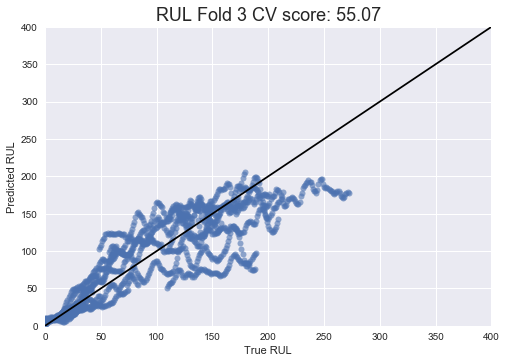

Mean CV Score: 187.48255920410156


In [40]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

lookback = 20

X, y, _, _, _, _, _, _, groups = \
create_lstm_datasets(train_df, test_df, sensor_columns, 'RUL_norm', lookback)

cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

In [57]:
lookback = 60

groups = get_lstm_groups(train_df, lookback=lookback)

group_ids = list(group_kfold.split(X, y, groups))

X, _ = get_lstm_X_sequences(train_df, test_df, features=sensor_columns, lookback=lookback)
y, _ = get_lstm_y_sequences(train_df, test_df, target='RUL_norm', lookback=lookback)

Epoch 1/10
13165/13165 [==============================] - 27s - loss: 0.0247 - rul_performance_metric_keras: 0.0095    
Epoch 2/10
13165/13165 [==============================] - 22s - loss: 0.0155 - rul_performance_metric_keras: 0.0074    
Epoch 3/10
13165/13165 [==============================] - 22s - loss: 0.0134 - rul_performance_metric_keras: 0.0067    
Epoch 4/10
13165/13165 [==============================] - 23s - loss: 0.0120 - rul_performance_metric_keras: 0.0064    
Epoch 5/10
13165/13165 [==============================] - 22s - loss: 0.0114 - rul_performance_metric_keras: 0.0062    
Epoch 6/10
13165/13165 [==============================] - 22s - loss: 0.0106 - rul_performance_metric_keras: 0.0060    
Epoch 7/10
13165/13165 [==============================] - 23s - loss: 0.0094 - rul_performance_metric_keras: 0.0056    
Epoch 8/10
13165/13165 [==============================] - 23s - loss: 0.0088 - rul_performance_metric_keras: 0.0054    
Epoch 9/10
13165/13165 [================

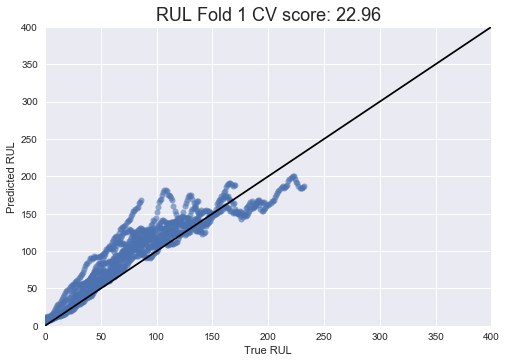

Epoch 1/10
13160/13160 [==============================] - 27s - loss: 0.0201 - rul_performance_metric_keras: 0.0085    
Epoch 2/10
13160/13160 [==============================] - 22s - loss: 0.0139 - rul_performance_metric_keras: 0.0069    
Epoch 3/10
13160/13160 [==============================] - 22s - loss: 0.0125 - rul_performance_metric_keras: 0.0065    
Epoch 4/10
13160/13160 [==============================] - 22s - loss: 0.0114 - rul_performance_metric_keras: 0.0062    
Epoch 5/10
13160/13160 [==============================] - 23s - loss: 0.0107 - rul_performance_metric_keras: 0.0060    
Epoch 6/10
13160/13160 [==============================] - 22s - loss: 0.0102 - rul_performance_metric_keras: 0.0058    
Epoch 7/10
13160/13160 [==============================] - 22s - loss: 0.0090 - rul_performance_metric_keras: 0.0055    
Epoch 8/10
13160/13160 [==============================] - 23s - loss: 0.0083 - rul_performance_metric_keras: 0.0053    
Epoch 9/10
13160/13160 [================

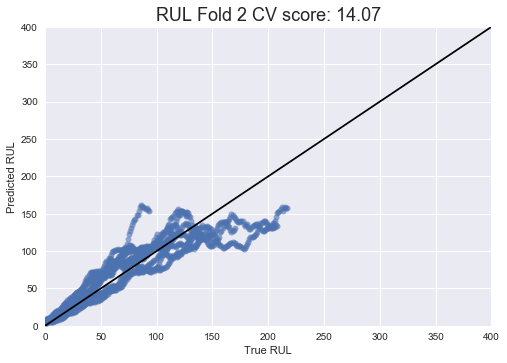

Epoch 1/10
13162/13162 [==============================] - 27s - loss: 0.0238 - rul_performance_metric_keras: 0.0093    
Epoch 2/10
13162/13162 [==============================] - 22s - loss: 0.0139 - rul_performance_metric_keras: 0.0070    
Epoch 3/10
13162/13162 [==============================] - 22s - loss: 0.0124 - rul_performance_metric_keras: 0.0065    
Epoch 4/10
13162/13162 [==============================] - 22s - loss: 0.0115 - rul_performance_metric_keras: 0.0062    
Epoch 5/10
13162/13162 [==============================] - 23s - loss: 0.0109 - rul_performance_metric_keras: 0.0061    
Epoch 6/10
13162/13162 [==============================] - 22s - loss: 0.0103 - rul_performance_metric_keras: 0.0059    
Epoch 7/10
13162/13162 [==============================] - 22s - loss: 0.0098 - rul_performance_metric_keras: 0.0058    
Epoch 8/10
13162/13162 [==============================] - 22s - loss: 0.0089 - rul_performance_metric_keras: 0.0055    
Epoch 9/10
13162/13162 [================

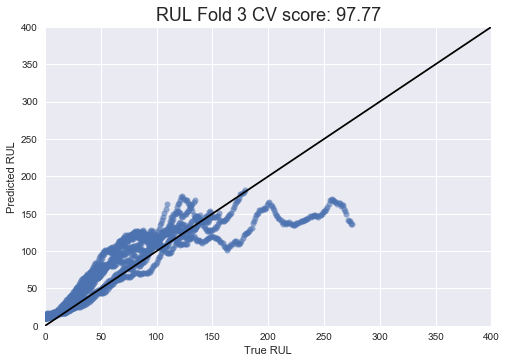

Mean CV Score: 44.93582534790039


In [55]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/10
13165/13165 [==============================] - 36s - loss: 0.0322 - rul_performance_metric_keras: 0.0103    
Epoch 2/10
13165/13165 [==============================] - 31s - loss: 0.0186 - rul_performance_metric_keras: 0.0077    
Epoch 3/10
13165/13165 [==============================] - 31s - loss: 0.0147 - rul_performance_metric_keras: 0.0070    
Epoch 4/10
13165/13165 [==============================] - 31s - loss: 0.0133 - rul_performance_metric_keras: 0.0068    
Epoch 5/10
13165/13165 [==============================] - 31s - loss: 0.0124 - rul_performance_metric_keras: 0.0067    
Epoch 6/10
13165/13165 [==============================] - 31s - loss: 0.0118 - rul_performance_metric_keras: 0.0066    
Epoch 7/10
13165/13165 [==============================] - 31s - loss: 0.0106 - rul_performance_metric_keras: 0.0062    
Epoch 8/10
13165/13165 [==============================] - 31s - loss: 0.0101 - rul_performance_metric_keras: 0.0060    
Epoch 9/10
13165/13165 [================

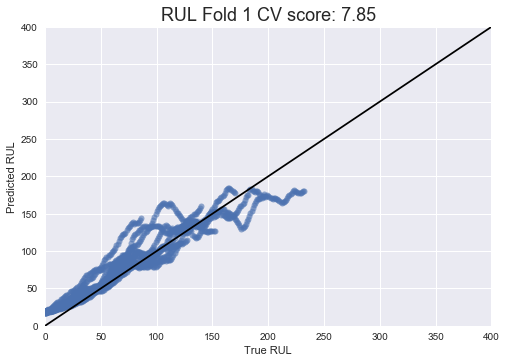

Epoch 1/10
13160/13160 [==============================] - 37s - loss: 0.0273 - rul_performance_metric_keras: 0.0096    
Epoch 2/10
13160/13160 [==============================] - 29s - loss: 0.0178 - rul_performance_metric_keras: 0.0076    
Epoch 3/10
13160/13160 [==============================] - 29s - loss: 0.0147 - rul_performance_metric_keras: 0.0070    
Epoch 4/10
13160/13160 [==============================] - 29s - loss: 0.0128 - rul_performance_metric_keras: 0.0066    
Epoch 5/10
13160/13160 [==============================] - 29s - loss: 0.0114 - rul_performance_metric_keras: 0.0063    
Epoch 6/10
13160/13160 [==============================] - 29s - loss: 0.0106 - rul_performance_metric_keras: 0.0061    
Epoch 7/10
13160/13160 [==============================] - 29s - loss: 0.0101 - rul_performance_metric_keras: 0.0060    
Epoch 8/10
13160/13160 [==============================] - 29s - loss: 0.0099 - rul_performance_metric_keras: 0.0060    
Epoch 9/10
13160/13160 [================

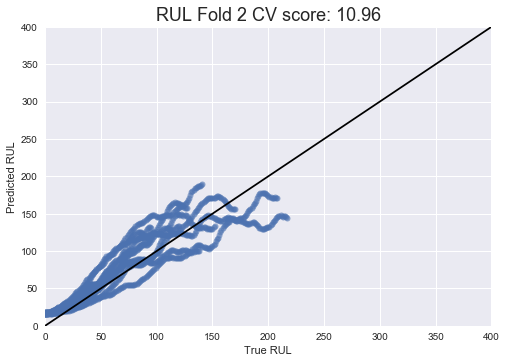

Epoch 1/10
13162/13162 [==============================] - 41s - loss: 0.0239 - rul_performance_metric_keras: 0.0089    
Epoch 2/10
13162/13162 [==============================] - 34s - loss: 0.0163 - rul_performance_metric_keras: 0.0072    
Epoch 3/10
13162/13162 [==============================] - 31s - loss: 0.0129 - rul_performance_metric_keras: 0.0064    
Epoch 4/10
13162/13162 [==============================] - 31s - loss: 0.0105 - rul_performance_metric_keras: 0.0059    
Epoch 5/10
13162/13162 [==============================] - 31s - loss: 0.0098 - rul_performance_metric_keras: 0.0058    
Epoch 6/10
13162/13162 [==============================] - 31s - loss: 0.0092 - rul_performance_metric_keras: 0.0057    
Epoch 7/10
13162/13162 [==============================] - 31s - loss: 0.0091 - rul_performance_metric_keras: 0.0057    
Epoch 8/10
13162/13162 [==============================] - 31s - loss: 0.0089 - rul_performance_metric_keras: 0.0056    
Epoch 9/10
13162/13162 [================

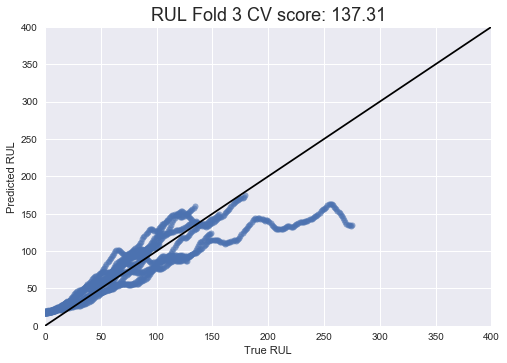

Mean CV Score: 52.03745651245117


In [59]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=5, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/20
13165/13165 [==============================] - 44s - loss: 0.0187 - rul_performance_metric_keras: 0.0081    
Epoch 2/20
13165/13165 [==============================] - 38s - loss: 0.0126 - rul_performance_metric_keras: 0.0065    
Epoch 3/20
13165/13165 [==============================] - 38s - loss: 0.0111 - rul_performance_metric_keras: 0.0062    
Epoch 4/20
13165/13165 [==============================] - 38s - loss: 0.0099 - rul_performance_metric_keras: 0.0058    
Epoch 5/20
13165/13165 [==============================] - 38s - loss: 0.0084 - rul_performance_metric_keras: 0.0054    
Epoch 6/20
13165/13165 [==============================] - 38s - loss: 0.0076 - rul_performance_metric_keras: 0.0051    
Epoch 7/20
13165/13165 [==============================] - 38s - loss: 0.0072 - rul_performance_metric_keras: 0.0049    
Epoch 8/20
13165/13165 [==============================] - 38s - loss: 0.0069 - rul_performance_metric_keras: 0.0048    
Epoch 9/20
13165/13165 [================

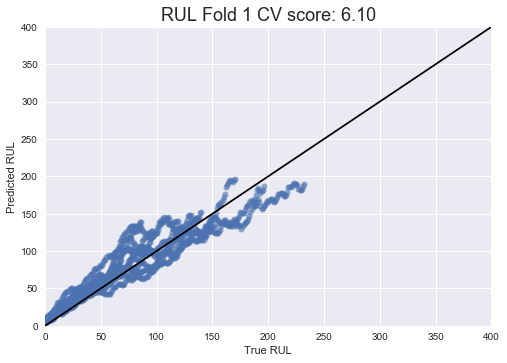

Epoch 1/20
13160/13160 [==============================] - 46s - loss: 0.0197 - rul_performance_metric_keras: 0.0083    
Epoch 2/20
13160/13160 [==============================] - 38s - loss: 0.0122 - rul_performance_metric_keras: 0.0064    
Epoch 3/20
13160/13160 [==============================] - 38s - loss: 0.0108 - rul_performance_metric_keras: 0.0060    
Epoch 4/20
13160/13160 [==============================] - 38s - loss: 0.0095 - rul_performance_metric_keras: 0.0057    
Epoch 5/20
13160/13160 [==============================] - 38s - loss: 0.0083 - rul_performance_metric_keras: 0.0052    
Epoch 6/20
13160/13160 [==============================] - 38s - loss: 0.0077 - rul_performance_metric_keras: 0.0050    
Epoch 7/20
13160/13160 [==============================] - 38s - loss: 0.0070 - rul_performance_metric_keras: 0.0048    
Epoch 8/20
13160/13160 [==============================] - 38s - loss: 0.0065 - rul_performance_metric_keras: 0.0047    
Epoch 9/20
13160/13160 [================

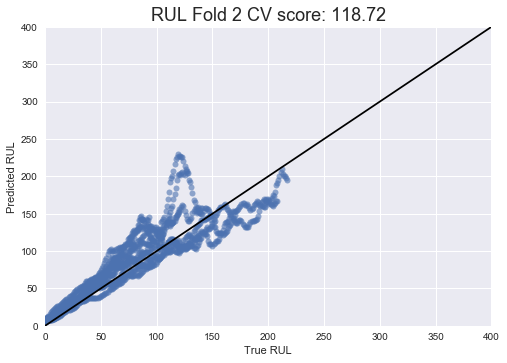

Epoch 1/20
13162/13162 [==============================] - 46s - loss: 0.0164 - rul_performance_metric_keras: 0.0076    
Epoch 2/20
13162/13162 [==============================] - 44s - loss: 0.0117 - rul_performance_metric_keras: 0.0063    
Epoch 3/20
13162/13162 [==============================] - 40s - loss: 0.0105 - rul_performance_metric_keras: 0.0059    
Epoch 4/20
13162/13162 [==============================] - 40s - loss: 0.0096 - rul_performance_metric_keras: 0.0057    
Epoch 5/20
13162/13162 [==============================] - 40s - loss: 0.0080 - rul_performance_metric_keras: 0.0052    
Epoch 6/20
13162/13162 [==============================] - 40s - loss: 0.0071 - rul_performance_metric_keras: 0.0049    
Epoch 7/20
13162/13162 [==============================] - 40s - loss: 0.0070 - rul_performance_metric_keras: 0.0048    
Epoch 8/20
13162/13162 [==============================] - 40s - loss: 0.0065 - rul_performance_metric_keras: 0.0047    
Epoch 9/20
13162/13162 [================

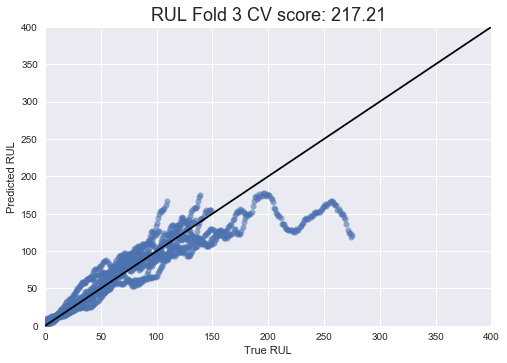

Mean CV Score: 114.01055145263672


In [60]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1)
    
    pred = model.predict(X_test)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

Epoch 1/20
13165/13165 [==============================] - 19s - loss: 0.0280 - rul_performance_metric_keras: 0.0101    
Epoch 2/20
13165/13165 [==============================] - 13s - loss: 0.0178 - rul_performance_metric_keras: 0.0081    
Epoch 3/20
13165/13165 [==============================] - 13s - loss: 0.0161 - rul_performance_metric_keras: 0.0076    
Epoch 4/20
13165/13165 [==============================] - 13s - loss: 0.0146 - rul_performance_metric_keras: 0.0072    
Epoch 5/20
13165/13165 [==============================] - 13s - loss: 0.0137 - rul_performance_metric_keras: 0.0069    
Epoch 6/20
13165/13165 [==============================] - 13s - loss: 0.0129 - rul_performance_metric_keras: 0.0067    
Epoch 7/20
13165/13165 [==============================] - 13s - loss: 0.0130 - rul_performance_metric_keras: 0.0067    
Epoch 8/20
13165/13165 [==============================] - 13s - loss: 0.0124 - rul_performance_metric_keras: 0.0064    
Epoch 9/20
13165/13165 [================

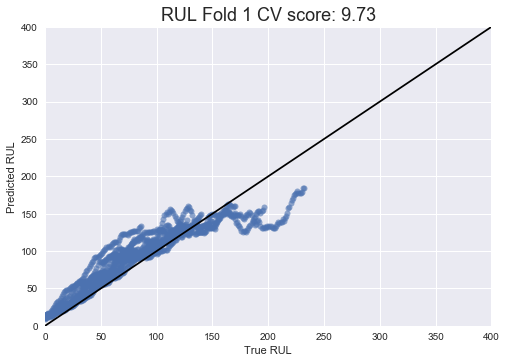

Epoch 1/20
13160/13160 [==============================] - 22s - loss: 0.0372 - rul_performance_metric_keras: 0.0114    
Epoch 2/20
13160/13160 [==============================] - 13s - loss: 0.0193 - rul_performance_metric_keras: 0.0084    
Epoch 3/20
13160/13160 [==============================] - 13s - loss: 0.0175 - rul_performance_metric_keras: 0.0079    
Epoch 4/20
13160/13160 [==============================] - 13s - loss: 0.0155 - rul_performance_metric_keras: 0.0074    
Epoch 5/20
13160/13160 [==============================] - 13s - loss: 0.0140 - rul_performance_metric_keras: 0.0070    
Epoch 6/20
13160/13160 [==============================] - 13s - loss: 0.0136 - rul_performance_metric_keras: 0.0068    
Epoch 7/20
13160/13160 [==============================] - 13s - loss: 0.0130 - rul_performance_metric_keras: 0.0066    
Epoch 8/20
13160/13160 [==============================] - 13s - loss: 0.0124 - rul_performance_metric_keras: 0.0065    
Epoch 9/20
13160/13160 [================

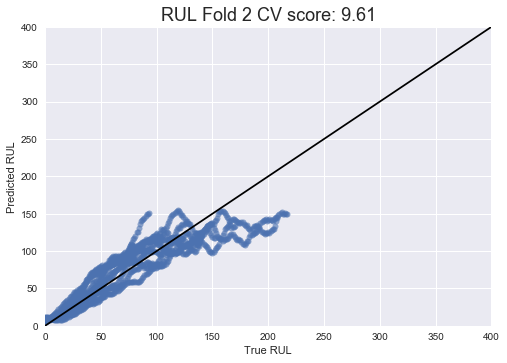

Epoch 1/20
13162/13162 [==============================] - 19s - loss: 0.0486 - rul_performance_metric_keras: 0.0124    
Epoch 2/20
13162/13162 [==============================] - 13s - loss: 0.0189 - rul_performance_metric_keras: 0.0083    
Epoch 3/20
13162/13162 [==============================] - 14s - loss: 0.0166 - rul_performance_metric_keras: 0.0077    
Epoch 4/20
13162/13162 [==============================] - 13s - loss: 0.0146 - rul_performance_metric_keras: 0.0071    
Epoch 5/20
13162/13162 [==============================] - 13s - loss: 0.0136 - rul_performance_metric_keras: 0.0068    
Epoch 6/20
13162/13162 [==============================] - 13s - loss: 0.0128 - rul_performance_metric_keras: 0.0066    
Epoch 7/20
13162/13162 [==============================] - 13s - loss: 0.0121 - rul_performance_metric_keras: 0.0064    
Epoch 8/20
13162/13162 [==============================] - 13s - loss: 0.0116 - rul_performance_metric_keras: 0.0063    
Epoch 9/20
13162/13162 [================

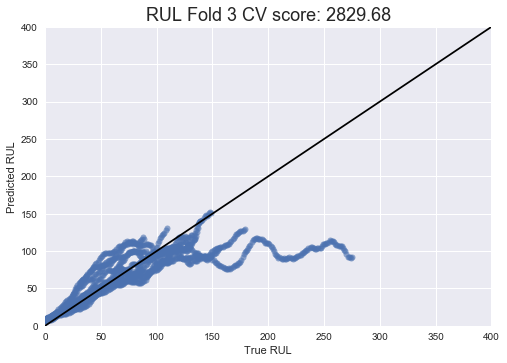

Mean CV Score: 949.672607421875


In [65]:
def get_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop',
                  metrics=[rul_performance_metric_keras])
    return model

cvscores = []
for i, idx in enumerate(ids_to_use):
    train_index, test_index = group_ids[idx]
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]            

    model = get_model()
    model.fit(X_train, y_train, epochs=20, batch_size=600, verbose=1)
    
    pred = model.predict(X_test, batch_size=1)
    pred = rul_scaler.inverse_transform(pred)
    
    y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
    score = rul_performance_metric(y_test, pred)
    title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
    plot_reg_result(y_test, pred, title=title, n=400, ms=12)
    
    cvscores.append(score)
    
print("Mean CV Score: {}".format(np.mean(cvscores)))

In [66]:
def get_lstm_model(target):
    model = Sequential()
    model.add(LSTM(50, input_shape=(lookback, len(sensor_columns)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.5))
    
    if target == 'RUL' or target == 'RUL_max':
        model.add(Dense(units=1))
        model.add(Activation('linear'))
        model.compile(loss='mean_squared_error', 
                      optimizer='rmsprop',
                      metrics=[rul_performance_metric_keras])
    elif target == 'label1':
        model.add(Dense(units=1))
        model.add(Activation('sigmoid'))
        model.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=[label1_performance_metric_keras])
    elif target == 'label2':
        model.add(Dense(units=3))
        model.add(Activation('softmax'))
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam', 
                      metrics=[label2_performance_metric_keras])
        
    return model

In [280]:
def lstm_cross_validate(X, y, target, n=400, verbose=0, epochs=20):
    cvscores = []
    group_kfold = GroupKFold(n_splits=10)
    group_ids = list(group_kfold.split(X, y, groups))
    ids_to_use = np.random.choice(len(group_ids), 3)

    
    # To inverse transform the predicted RUL values back
    if target == 'RUL':
        rul_scaler = MinMaxScaler().fit(train_df.RUL.reshape(-1, 1))
    elif target == 'RUL_max':
        rul_scaler = MinMaxScaler().fit(train_df.RUL_max.reshape(-1, 1))
        
    for i, idx in enumerate(ids_to_use):
        train_index, test_index = group_ids[idx]
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]            
        
        model = get_lstm_model(target)
        model.fit(X_train, y_train, epochs=epochs, batch_size=200, verbose=verbose)
        pred = model.predict(X_test, batch_size=1)
        
        if target == 'RUL' or target == 'RUL_max':
            pred = rul_scaler.inverse_transform(pred)
            y_test = rul_scaler.inverse_transform(y_test.reshape(-1, 1))
            score = rul_performance_metric(y_test, pred)
            title = 'RUL Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
            plot_reg_result2(y_test, pred, title=title, n=n, ms=5)
            
        elif target == 'label1':
            pred = np.round(pred)
            score = label1_performance_metric(y_test, pred)
            title = 'Label 1 Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
            plot_cm2(y_test, pred, title=title, multi=False)
            
        elif target == 'label2':
            pred = np.asarray([np.argmax(p) for p in pred])
            score = label2_performance_metric(y_test, pred)
            title = 'Label 2 Fold ' + str(i+1) + ' CV score: {0:.2f}'.format(score)
            plot_cm2(y_test, pred, title=title, multi=True)
                               
        cvscores.append(score)
        
    return np.mean(cvscores)

In [ ]:
# LSTM datsets

lookback = 60

X_train, X_test = get_lstm_X_sequences(train_df, test_df, features=sensor_columns, lookback=lookback)
y_train_rul, y_test_rul = get_lstm_y_sequences(train_df, test_df, target='RUL_norm', lookback=lookback)
y_train_label1, y_test_label1 = get_lstm_y_sequences(train_df, test_df, target='label1', lookback=lookback)
y_train_label2, y_test_label2 = get_lstm_y_sequences(train_df, test_df, target='label2', lookback=lookback)

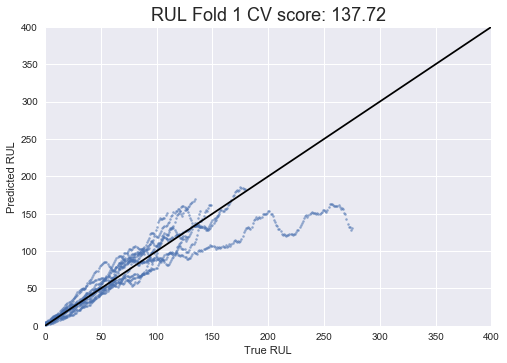

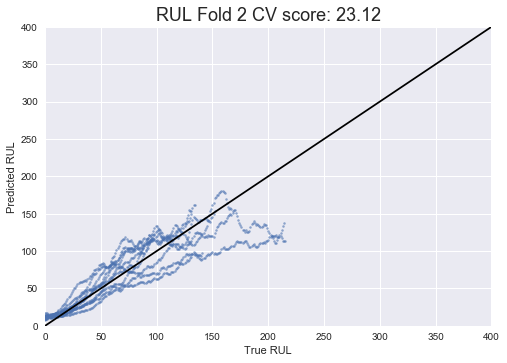

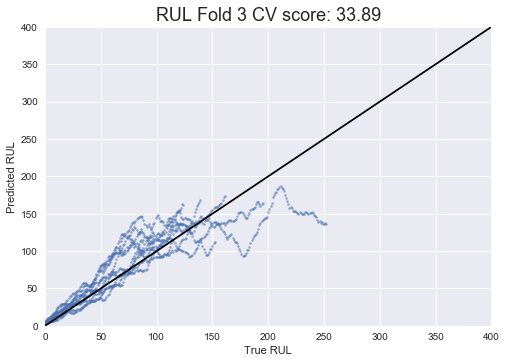

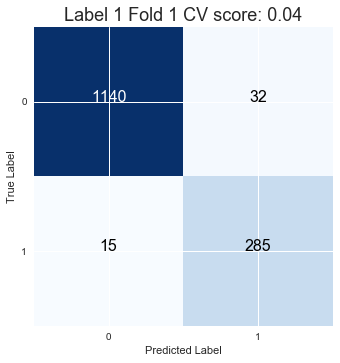

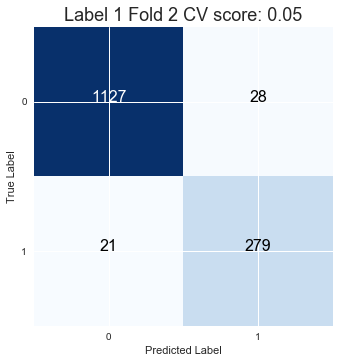

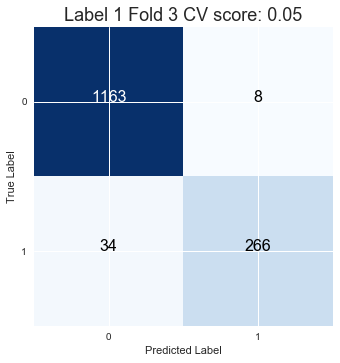

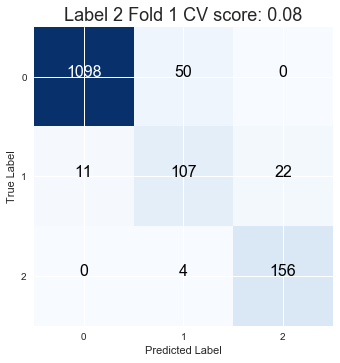

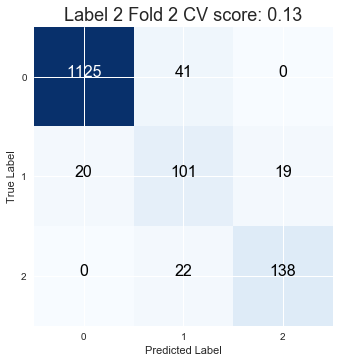

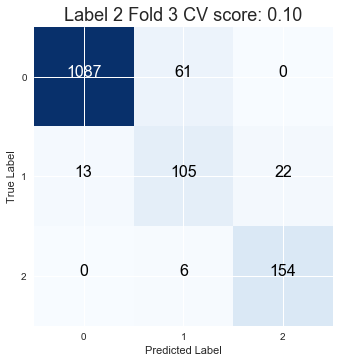

Fitting RUL Model...
Epoch 1/20
14631/14631 [==============================] - 34s - loss: 0.0203 - rul_performance_metric_keras: 0.0085    
Epoch 2/20
14631/14631 [==============================] - 26s - loss: 0.0136 - rul_performance_metric_keras: 0.0069    
Epoch 3/20
14631/14631 [==============================] - 26s - loss: 0.0118 - rul_performance_metric_keras: 0.0064    
Epoch 4/20
14631/14631 [==============================] - 26s - loss: 0.0110 - rul_performance_metric_keras: 0.0061    
Epoch 5/20
14631/14631 [==============================] - 26s - loss: 0.0102 - rul_performance_metric_keras: 0.0059    
Epoch 6/20
14631/14631 [==============================] - 26s - loss: 0.0098 - rul_performance_metric_keras: 0.0058    
Epoch 7/20
14631/14631 [==============================] - 26s - loss: 0.0093 - rul_performance_metric_keras: 0.0056    
Epoch 8/20
14631/14631 [==============================] - 26s - loss: 0.0083 - rul_performance_metric_keras: 0.0053    
Epoch 9/20
14631/14

,LSTM_CV,LSTM_Test
RUL,64.91,77.32
Label1,0.05,0.10
Label2,0.10,0.15


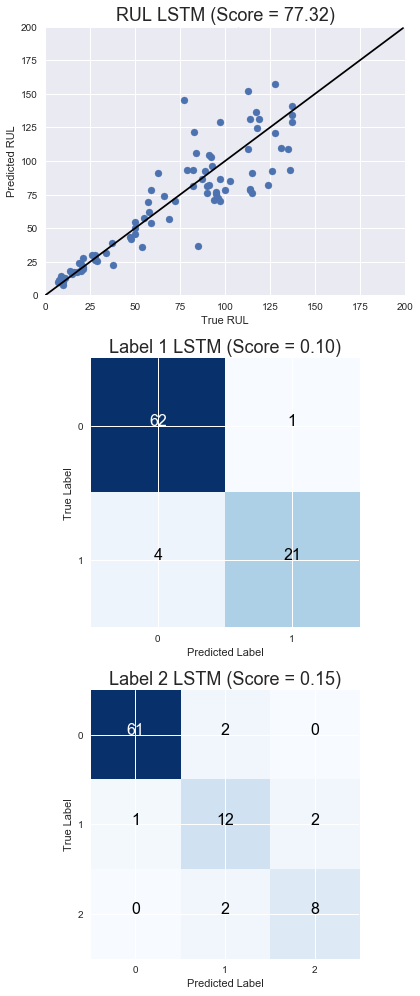

In [69]:
# Cross Val Scores
rul_cv_score = lstm_cross_validate(X_train, y_train_rul, target='RUL')
label1_cv_score = lstm_cross_validate(X_train, y_train_label1, target='label1')
label2_cv_score = lstm_cross_validate(X_train, y_train_label2, target='label2')

# Make predictions on test set
rul_model = get_lstm_model('RUL')
label1_model = get_lstm_model('label1')
label2_model = get_lstm_model('label2')

print('Fitting RUL Model...')
rul_model.fit(X_train, y_train_rul, epochs=20, batch_size=200, verbose=1)
print('\nFitting Label1 Model...')
label1_model.fit(X_train, y_train_label1, epochs=20, batch_size=200, verbose=1)
print('\nFitting Label2 Model...')
label2_model.fit(X_train, y_train_label2, epochs=20, batch_size=200, verbose=1)

rul_pred_norm = rul_model.predict(X_test, batch_size=1)
rul_pred = MinMaxScaler().fit(train_df.RUL.reshape(-1, 1)).inverse_transform(rul_pred_norm)

label1_pred = np.round(label1_model.predict(X_test, batch_size=1))

label2_probabilities = label2_model.predict(X_test, batch_size=1)
label2_pred = np.asarray([np.argmax(p) for p in label2_probabilities])

# Get scores on test set
rul_test_score = rul_performance_metric(y_test_rul, rul_pred)
label1_test_score = label1_performance_metric(y_test_label1, label1_pred)
label2_test_score = label2_performance_metric(y_test_label2, label2_pred)

results_df_cv['LSTM_CV'] = [lrul_cv_score, label1_cv_score, label2_cv_score]
results_df_test['LSTM_Test'] = [rul_test_score, label1_test_score, label2_test_score]

display(pd.concat([results_df_cv, results_df_test], axis=1)[['LSTM_CV', 'LSTM_Test']].round(2))

titles = [
    'RUL LSTM (Score = {0:.2f})'.format(rul_test_score),
    'Label 1 LSTM (Score = {0:.2f})'.format(label1_test_score),
    'Label 2 LSTM (Score = {0:.2f})'.format(label2_test_score)
]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,14))
plot_regression_result(y_test_rul, rul_pred, title=titles[0], n=200, ax=ax1)
plot_cm(y_test_label1, label1_pred, titles[1], multi=False, ax=ax2)
plot_cm(y_test_label2, label2_pred, titles[2], multi=True, ax=ax3)
plt.tight_layout()
savefig('lstm_results')

In [70]:
# Save Models

with open("models/new/rul_model.json", "w") as json_file:
    json_file.write(rul_model.to_json())
    
with open("models/new/label1_model.json", "w") as json_file:
    json_file.write(label1_model.to_json())
    
with open("models/new/label2_model.json", "w") as json_file:
    json_file.write(label2_model.to_json())

## Max RUL

,RandomForrest_CV_RUL_Max,RandomForrest_Test_RUL_Max
RUL,1.65,9.54
Label1,0.07,0.17
Label2,0.15,0.32


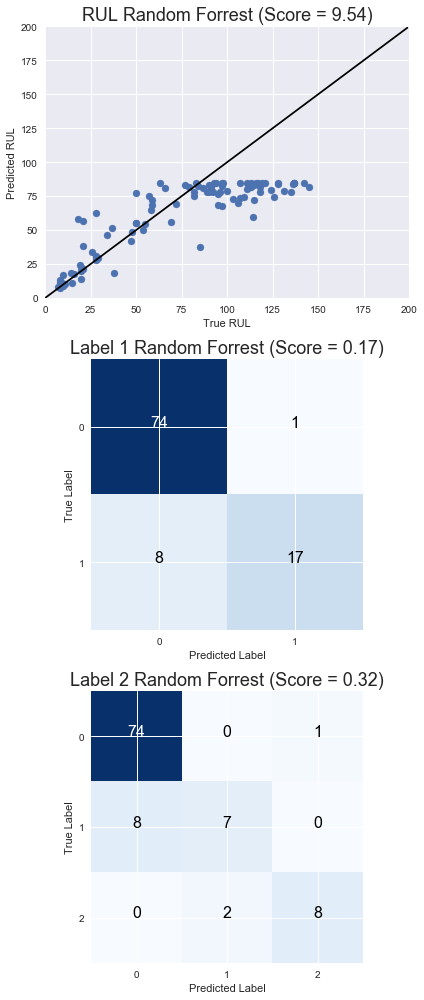

In [305]:
# Use only the sensor values as the input features
X_train = train_df[feature_columns]
y_train_rul = train_df['RUL_max']
y_train_label1 = train_df['label1']
y_train_label2 = train_df['label2']

# Use the last cycle for each engine unit as the test set
X_test = test_df.groupby('id')[feature_columns].last()
y_test_rul = test_df.groupby('id')['RUL'].last()
y_test_label1 = test_df.groupby('id')['label1'].last()
y_test_label2 = test_df.groupby('id')['label2'].last()

rul_model = RandomForestRegressor(random_state=42)
label1_model = RandomForestClassifier(random_state=42)
label2_model = RandomForestClassifier(random_state=42)

# CrossVal Scores
rul_cv_result = rul_score(rul_model, X_train, y_train_rul)
label1_cv_result = label1_score(label1_model, X_train, y_train_label1)
label2_cv_result = label2_score(label2_model, X_train, y_train_label2)

# Make predictions on test set
rul_pred = rul_model.fit(X_train, y_train_rul).predict(X_test)
label1_pred = label1_model.fit(X_train, y_train_label1).predict(X_test)
label2_pred = label2_model.fit(X_train, y_train_label2).predict(X_test)

# Get scores on test set
rul_test_score = rul_performance_metric(y_test_rul, rul_pred)
label1_test_score = label1_performance_metric(y_test_label1, label1_pred)
label2_test_score = label2_performance_metric(y_test_label2, label2_pred)

results_df_cv['RandomForrest_CV_RUL_Max'] = [rul_cv_result, label1_cv_result, label2_cv_result]
results_df_test['RandomForrest_Test_RUL_Max'] = [rul_test_score, label1_test_score, label2_test_score]

display(pd.concat([results_df_cv, results_df_test], axis=1)[['RandomForrest_CV_RUL_Max', 'RandomForrest_Test_RUL_Max']].round(2))


titles = [
    'RUL Random Forrest (Score = {0:.2f})'.format(rul_test_score),
    'Label 1 Random Forrest (Score = {0:.2f})'.format(label1_test_score),
    'Label 2 Random Forrest (Score = {0:.2f})'.format(label2_test_score)
]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,14))
plot_regression_result(y_test_rul, rul_pred, title=titles[0], n=200, ax=ax1)
plot_cm(y_test_label1, label1_pred, titles[1], multi=False, ax=ax2)
plot_cm(y_test_label2, label2_pred, titles[2], multi=True, ax=ax3)
plt.tight_layout()
savefig('rf_results_max')

In [294]:
# LSTM datsets

lookback = 60

X_train, X_test = get_lstm_X_sequences(train_df, test_df, features=sensor_columns, lookback=lookback)
y_train_rul, y_test_rul = get_lstm_y_sequences(train_df, test_df, target='RUL_max_norm', lookback=lookback)

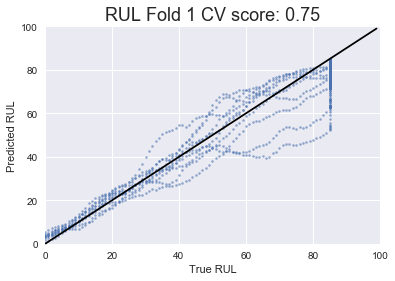

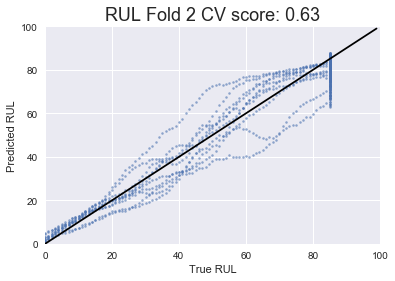

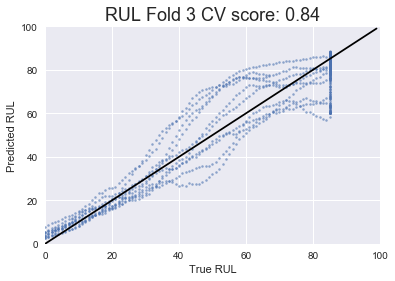

Epoch 1/20
14631/14631 [==============================] - 37s - loss: 0.0931 - rul_performance_metric_keras: 0.0192    
Epoch 2/20
14631/14631 [==============================] - 26s - loss: 0.0587 - rul_performance_metric_keras: 0.0155    
Epoch 3/20
14631/14631 [==============================] - 26s - loss: 0.0484 - rul_performance_metric_keras: 0.0140    
Epoch 4/20
14631/14631 [==============================] - 26s - loss: 0.0403 - rul_performance_metric_keras: 0.0127    
Epoch 5/20
14631/14631 [==============================] - 26s - loss: 0.0364 - rul_performance_metric_keras: 0.0120    
Epoch 6/20
14631/14631 [==============================] - 26s - loss: 0.0325 - rul_performance_metric_keras: 0.0113    
Epoch 7/20
14631/14631 [==============================] - 26s - loss: 0.0283 - rul_performance_metric_keras: 0.0105    
Epoch 8/20
14631/14631 [==============================] - 26s - loss: 0.0269 - rul_performance_metric_keras: 0.0102    
Epoch 9/20
14631/14631 [================

,LSTM_CV_Max_RUL,LSTM_Test_Max_RUL
RUL,0.74,6.82
Label1,NaN,NaN
Label2,NaN,NaN


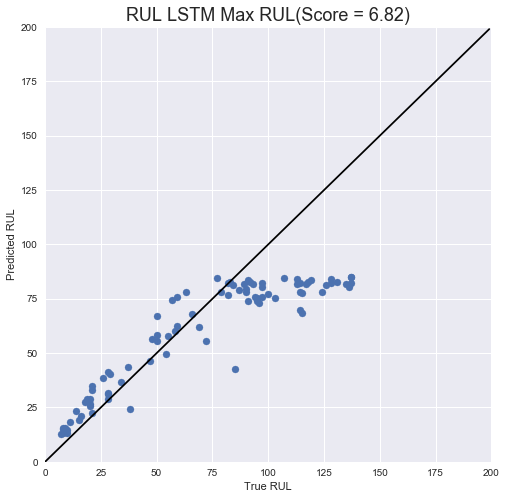

In [295]:
# Cross Val Scores
rul_cv_score = lstm_cross_validate(X_train, y_train_rul, target='RUL_max', n=100)

# Make predictions on test set
rul_model = get_lstm_model('RUL')

rul_model.fit(X_train, y_train_rul, epochs=20, batch_size=200, verbose=1)

rul_pred_norm = rul_model.predict(X_test, batch_size=1)
rul_pred = MinMaxScaler().fit(train_df['RUL_max'].reshape(-1, 1)).inverse_transform(rul_pred_norm).reshape(-1)

# Get scores on test set
rul_test_score = rul_performance_metric(y_test_rul, rul_pred)

results_df_cv['LSTM_CV_Max_RUL'] = [rul_cv_score, np.nan, np.nan]
results_df_test['LSTM_Test_Max_RUL'] = [rul_test_score, np.nan, np.nan]

display(pd.concat([results_df_cv, results_df_test], axis=1)[['LSTM_CV_Max_RUL', 'LSTM_Test_Max_RUL']].round(2))

# Plot the results
fig,ax=plt.subplots(figsize=(8,8))
plot_regression_result(y_test_rul, rul_pred, title='RUL LSTM Max RUL(Score = {0:.2f})'.format(rul_test_score), n=200,ax=ax)
savefig('LSTM_Max_RUL_results')

# Model Validation

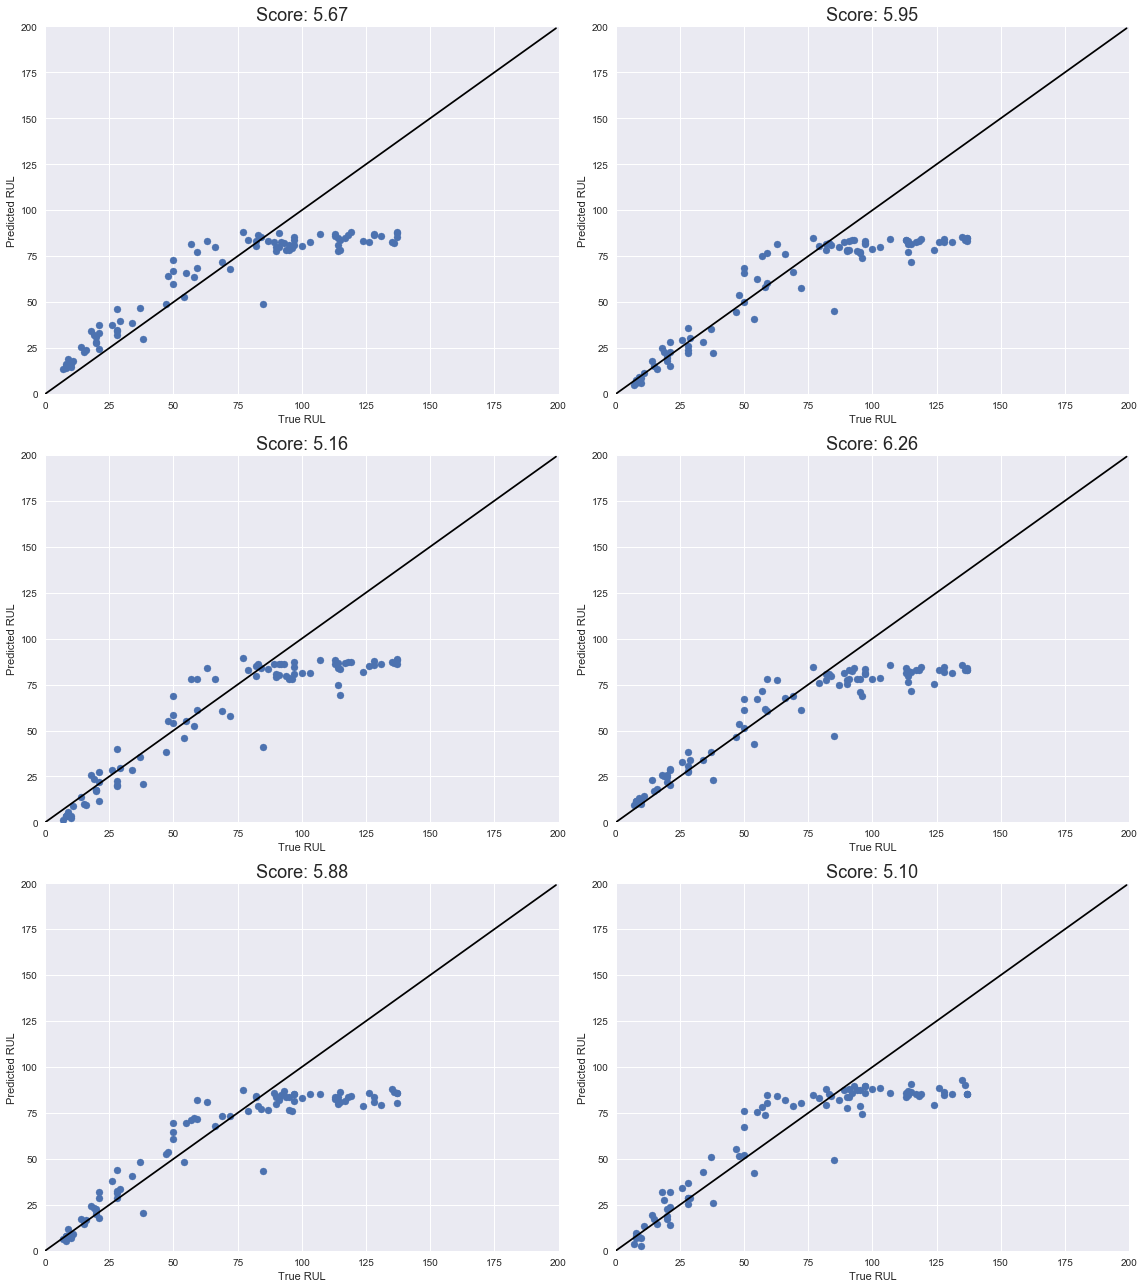

In [302]:
# Make predictions on test set
X_train, X_test = get_lstm_X_sequences(train_df, test_df, features=sensor_columns, lookback=lookback)

fig, axes = plt.subplots(3,2, figsize=(16, 18))
axes = axes.ravel()

for i in range(2,8):
    y_train, y_test = get_lstm_y_sequences(train_df, test_df, target='RUL_max_norm', lookback=lookback)
    model = get_lstm_model('RUL')
    model.fit(X_train, y_train, epochs=20, batch_size=200, verbose=0)

    y_pred_norm = model.predict(X_test, batch_size=1)
    y_pred = MinMaxScaler().fit(train_df['RUL_max'].reshape(-1, 1)).inverse_transform(y_pred_norm).reshape(-1)

    # Get scores on test set
    score = rul_performance_metric(y_test, y_pred)
    
    plot_regression_result(y_test, y_pred, title='Score: {0:.2f}'.format(score), n=200, ax=axes[i-2])

plt.tight_layout()
savefig('val_lstm')

# Results

In [366]:
results_df_cv.transpose().sort_values(by='RUL', ascending=False)

,RUL,Label1,Label2
RandomForrest_CV_tuned,46637.684844,0.072706,0.159760
RandomForrest_CV,21410.325865,0.069459,0.152878
Benchmark_CV,5200.737650,0.062334,0.180214
LSTM_CV,64.911125,0.047298,0.101454
RandomForrest_CV_RUL_Max,1.651039,0.069459,0.152878
LSTM_CV_RUL_Max,0.741079,0.047298,0.101454


In [360]:
results_df_test.transpose().sort_values(by='RUL', ascending=False)

,RUL,Label1,Label2
RandomForrest_Test,5648.685177,0.170000,0.320000
RandomForrest_Test_tuned,521.823052,0.150000,0.380000
Benchmark_Test,81.075776,0.150000,0.390000
LSTM_Test,77.321907,0.102273,0.147727
RandomForrest_Test_RUL_Max,9.542447,0.170000,0.320000
LSTM_Test_RUL_Max,6.820150,0.102273,0.147727


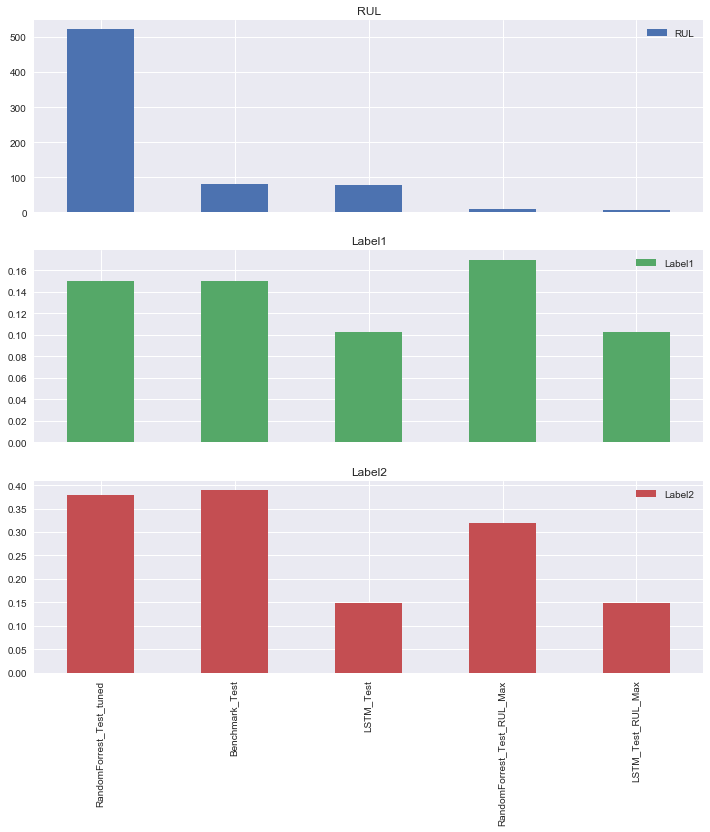

In [379]:
results_df_test.drop("RandomForrest_Test", axis=1).transpose().sort_values(by=['RUL'], ascending=False).plot(kind="bar", subplots=True, figsize=(12,12), sort_columns=True)
savefig('results_bar')